In [1]:
import requests
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import nltk
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
train = dd.read_json('data/train.jsonl', lines=True)
validation = dd.read_json('data/validation.jsonl', lines=True)
test = dd.read_json('data/test.jsonl', lines=True)

In [3]:
tokenizer = TweetTokenizer()
def preprocess(row):
    tokens = tokenizer.tokenize(row.lower())
    return ' '.join(tokens)

In [4]:
train['text'] = train['text'].map_partitions(lambda partition: partition.apply(preprocess), meta=train['text'])
train = train.compute()

In [5]:
validation['text'] = validation['text'].map_partitions(lambda partition: partition.apply(preprocess), meta=validation['text'])
validation = validation.compute()

In [6]:
test['text'] = test['text'].map_partitions(lambda partition: partition.apply(preprocess), meta=test['text'])
test = test.compute()

In [7]:
train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [26]:
validation.iloc[round(validation.shape[0]/2)-3:round(validation.shape[0]/2)+2, :]

,text,label
997,i feel as if there is anyone who really unders...,3
998,i know jack and he doesnt give up on men easy ...,1
999,i feel shy now,4
1000,i feel and im amazed of how often i think i ne...,5
1001,i feel a cold or sore throat coming on i simpl...,3


In [9]:
test.tail()

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0


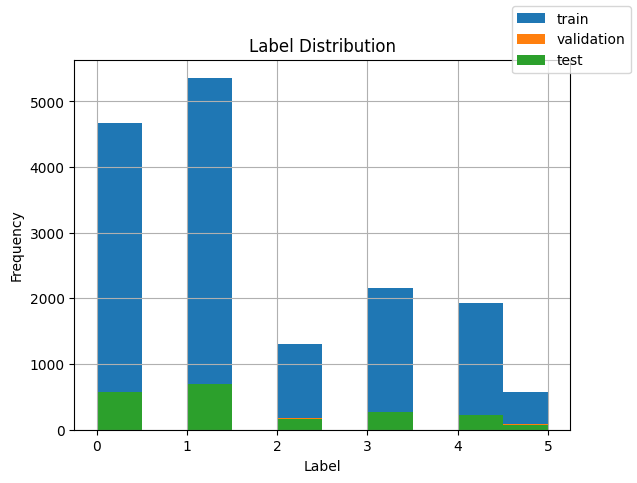

In [10]:
fig = plt.figure()
for target in [train, validation, test]:
    target['label'].hist()
fig.legend(['train','validation','test'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [11]:
vectorizer = TfidfVectorizer()
def apply_tfidf(docs):
    return vectorizer.fit_transform(docs)

In [12]:
vectorizer = TfidfVectorizer()
vectorizer.fit(train['text'])

TfidfVectorizer()

In [13]:
train_tfidf = vectorizer.transform(train['text'])
validation_tfidf = vectorizer.transform(validation['text'])
test_tfidf = vectorizer.transform(test['text'])

In [14]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'

In [15]:
train_label = torch.tensor(train['label']).to(device)
train_vectors = torch.tensor(train_tfidf.toarray(), dtype=torch.float).to(device)
train_dataset = TensorDataset(train_vectors, train_label)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [16]:
validation_label = torch.tensor(validation['label']).to(device)
validation_vectors = torch.tensor(validation_tfidf.toarray(), dtype=torch.float).to(device)
validation_dataset = TensorDataset(validation_vectors, validation_label)
validation_loader = DataLoader(validation_dataset, shuffle=True)

In [17]:
test_label = torch.tensor(test['label']).to(device)
test_vectors = torch.tensor(test_tfidf.toarray(), dtype=torch.float).to(device)
test_dataset = TensorDataset(test_vectors, test_label)
test_loader = DataLoader(test_dataset, shuffle=True)

In [18]:
def layer_init(layer, std=1, bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

In [19]:
class EmotionClassifier(nn.Module):
    def __init__(self, n_features, n_labels):
        super().__init__()
        self.hidden = nn.Sequential(
            layer_init(nn.Linear(n_features, 128)),
            nn.ReLU(),
            layer_init(nn.Linear(128, 128)),
            nn.ReLU()
        )
        self.output = layer_init(nn.Linear(128, n_labels))
    def forward(self, x):
        x = self.hidden(x)
        logits = self.output(x)
        return logits

In [20]:
model = EmotionClassifier(train_vectors.size(1), len(train_label.unique()))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    model.train()
    for batch, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        if batch % 10 == 0:
            print(f"train loss: {loss.item()}")
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X, y in validation_loader:
            y_pred = model(X)
            val_loss += criterion(y_pred, y).item()
        val_loss /= len(validation_loader)
        print(f"val loss: {val_loss}")

Epoch 1
-------------------------------
train loss: 1.7918953895568848
train loss: 1.7509373426437378
train loss: 1.6449426412582397
train loss: 1.5929169654846191
train loss: 1.5004347562789917
train loss: 1.4134035110473633
train loss: 1.4260116815567017
train loss: 1.382973074913025
train loss: 1.2337838411331177
train loss: 1.2669506072998047
train loss: 1.2010940313339233
train loss: 0.9155514240264893
train loss: 0.9602771997451782
train loss: 0.9867504835128784
train loss: 0.8416369557380676
train loss: 0.5508446097373962
val loss: 0.6708252263029572
Epoch 2
-------------------------------
train loss: 0.47066324949264526
train loss: 0.44288843870162964
train loss: 0.3852543532848358
train loss: 0.3316931128501892
train loss: 0.43875616788864136
train loss: 0.3092786371707916
train loss: 0.32842516899108887
train loss: 0.3572857975959778
train loss: 0.2949424684047699
train loss: 0.27551862597465515
train loss: 0.28291282057762146
train loss: 0.3026210069656372
train loss: 0.3265

In [22]:
from sklearn.metrics import classification_report
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for X, y in test_loader:
        y_pred = torch.argmax(model(X), 1)
        all_preds.extend(y_pred.cpu().numpy())
        all_true.extend(y.cpu().numpy())
    print("Validation Classification Report:\n")
    print(classification_report(all_true, all_preds))

Validation Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       581
           1       0.88      0.91      0.89       695
           2       0.75      0.75      0.75       159
           3       0.90      0.81      0.85       275
           4       0.81      0.85      0.83       224
           5       0.81      0.64      0.71        66

    accuracy                           0.87      2000
   macro avg       0.84      0.81      0.82      2000
weighted avg       0.87      0.87      0.86      2000



In [23]:
torch.save(model.state_dict(), "emotion_classifier.pth")